In [1]:
# Get the data
!wget https://raw.githubusercontent.com/datasciencedojo/datasets/master/titanic.csv

--2023-12-15 15:19:48--  https://raw.githubusercontent.com/datasciencedojo/datasets/master/titanic.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 60302 (59K) [text/plain]
Saving to: ‘titanic.csv.2’

titanic.csv.2       100%[===================>]  58.89K  --.-KB/s    in 0.02s   

2023-12-15 15:19:48 (3.47 MB/s) - ‘titanic.csv.2’ saved [60302/60302]



In [2]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# Load the Titanic dataset
df = pd.read_csv('titanic.csv')

In [4]:
# Data Exploration -- we can do a lot more than this of course
print(df.head())
print(df.describe())
print(df.info())

   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450   8.0500   NaN        S  
  

In [5]:
# Split the data into features (X) and target variable (y)
X = df.drop(columns=['Survived'])
y = df['Survived']

In [6]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [7]:
# Data Cleaning
X_train.drop(columns=['Name', 'Cabin', 'Ticket', 'PassengerId'], inplace=True)
X_test.drop(columns=['Name', 'Cabin', 'Ticket', 'PassengerId'], inplace=True)

In [8]:
X_train['Embarked'].fillna('S', inplace=True)
X_test['Embarked'].fillna('S', inplace=True)

In [9]:
X_train['Age'].fillna(X_train['Age'].median(), inplace=True)
X_test['Age'].fillna(X_test['Age'].median(), inplace=True)

In [10]:
# Feature Engineering
X_train['FamilySize'] = X_train['SibSp'] + X_train['Parch'] + 1
X_train['IsAlone'] = 0
X_train.loc[X_train['FamilySize'] == 1, 'IsAlone'] = 1

In [11]:
X_test['FamilySize'] = X_test['SibSp'] + X_test['Parch'] + 1
X_test['IsAlone'] = 0
X_test.loc[X_test['FamilySize'] == 1, 'IsAlone'] = 1

In [12]:
# Imputation
imputer = SimpleImputer(strategy='most_frequent')
X_train[['Sex', 'Embarked']] = imputer.fit_transform(X_train[['Sex', 'Embarked']])
X_test[['Sex', 'Embarked']] = imputer.transform(X_test[['Sex', 'Embarked']])

In [13]:
# Feature Selection -- highly correlated with the FamilySize variable which we engineered
X_train.drop(columns=['SibSp', 'Parch'], inplace=True)
X_test.drop(columns=['SibSp', 'Parch'], inplace=True)

In [15]:
X_train

,Pclass,Sex,Age,Fare,Embarked,FamilySize,IsAlone
331,1,male,45.5,28.5000,S,1,1
733,2,male,23.0,13.0000,S,1,1
382,3,male,32.0,7.9250,S,1,1
704,3,male,26.0,7.8542,S,2,0
813,3,female,6.0,31.2750,S,7,0
...,...,...,...,...,...,...,...
106,3,female,21.0,7.6500,S,1,1
270,1,male,28.0,31.0000,S,1,1
860,3,male,41.0,14.1083,S,3,0
435,1,female,14.0,120.0000,S,4,0


In [16]:
# Convert categorical variables to numerical
X_train['Sex'] = X_train['Sex'].map({'male': 0, 'female': 1}).astype(int)
X_test['Sex'] = X_test['Sex'].map({'male': 0, 'female': 1}).astype(int)
X_train = pd.get_dummies(X_train, columns=['Embarked'])
X_test = pd.get_dummies(X_test, columns=['Embarked'])

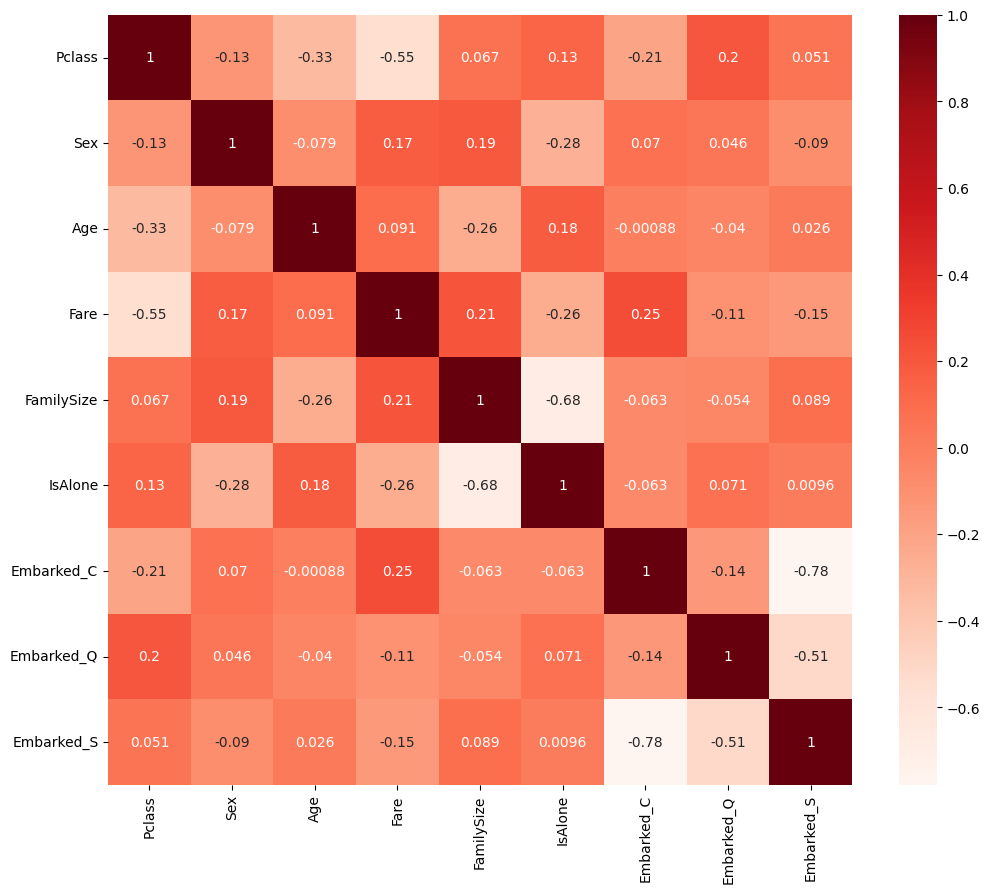

In [17]:
# Examine correlation matrix
corr_matrix = X_train.corr()
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap=plt.cm.Reds)
plt.show()

In [18]:
# Dealing with Imbalanced Classes
ros = RandomOverSampler()
rus = RandomUnderSampler()
smote = SMOTE()

In [19]:
# Apply resampling only to the training data
X_train_ros, y_train_ros = ros.fit_resample(X_train, y_train)
X_train_rus, y_train_rus = rus.fit_resample(X_train, y_train)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

In [21]:
# Data Scaling
scaler = StandardScaler()
X_train_ros_scaled = scaler.fit_transform(X_train_ros)
X_train_rus_scaled = scaler.fit_transform(X_train_rus)
X_train_smote_scaled = scaler.fit_transform(X_train_smote)
X_test_orig_scaled = scaler.transform(X_test)

In [22]:
# Hyperparameter Tuning
from sklearn.model_selection import GridSearchCV
lr = LogisticRegression()
dt = DecisionTreeClassifier()
rf = RandomForestClassifier()

param_grid = {'C': [0.01, 0.1, 1, 10, 100]}
grid_lr = GridSearchCV(lr, param_grid, cv=5)
grid_lr.fit(X_train_ros_scaled, y_train_ros)

print('Best Parameters for Logistic Regression:', grid_lr.best_params_)

param_grid = {'max_depth': [3, 5, 7, 10], 'min_samples_leaf': [2, 5, 10]}
grid_dt = GridSearchCV(dt, param_grid, cv=5)
grid_dt.fit(X_train_ros_scaled, y_train_ros)

print('Best Parameters for Decision Tree:', grid_dt.best_params_)

param_grid = {'n_estimators': [50, 100, 150], 'max_depth': [3, 5, 7, 10]}
grid_rf = GridSearchCV(rf, param_grid, cv=5)
grid_rf.fit(X_train_ros_scaled, y_train_ros)

print('Best Parameters for Random Forest:', grid_rf.best_params_)

Best Parameters for Logistic Regression: {'C': 1}
Best Parameters for Decision Tree: {'max_depth': 10, 'min_samples_leaf': 2}
Best Parameters for Random Forest: {'max_depth': 10, 'n_estimators': 50}


In [23]:
# Final Model
final_model = grid_rf.best_estimator_
final_model.fit(X_train_ros_scaled, y_train_ros)

RandomForestClassifier(max_depth=10, n_estimators=50)

In [24]:
# Model Evaluation on Test Set
y_pred = final_model.predict(X_test_orig_scaled)
print('Final Model Evaluation on Test Set')
print('Accuracy:', accuracy_score(y_test, y_pred))
print('Precision:', precision_score(y_test, y_pred))
print('Recall:', recall_score(y_test, y_pred))
print('F1 Score:', f1_score(y_test, y_pred))

Final Model Evaluation on Test Set
Accuracy: 0.8100558659217877
Precision: 0.803030303030303
Recall: 0.7162162162162162
F1 Score: 0.7571428571428571


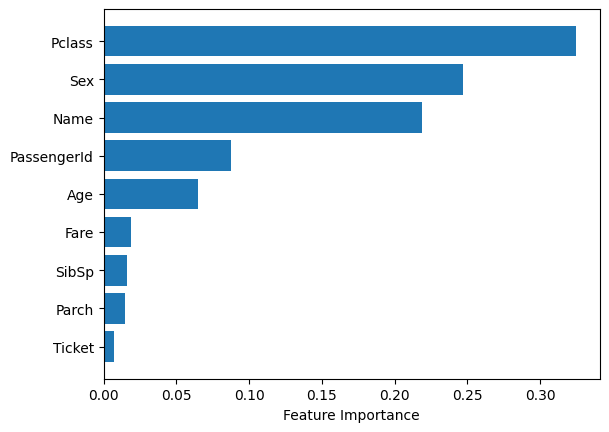

In [25]:
# Feature Importance
feature_importance = final_model.feature_importances_
feature_names = X.columns
sorted_idx = feature_importance.argsort()

import matplotlib.pyplot as plt
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx])
plt.yticks(range(len(sorted_idx)), [feature_names[i] for i in sorted_idx])
plt.xlabel('Feature Importance')
plt.show()